In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
from sklearn.preprocessing import MinMaxScaler
import seaborn as sns
import librosa
import torch
from scipy.stats import skew, kurtosis
from sklearn.cluster import KMeans
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.layers import Input,Dense, Dropout
from tensorflow.keras.models import Model
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

### Function to create MFCC coefficients

In [2]:
def create_MFCC_coefficients(file_name):
    sr_value = 44100
    n_mfcc_count = 20
    try:
        y, sr = librosa.load(file_name, sr=sr_value)
        mfccs = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=n_mfcc_count)
        coeff_df = pd.DataFrame(mfccs)
        return coeff_df.T
    except:
        return None

## GTZAN data for pretraining 

In [3]:
L = 2584  
gtzan_Data = []
gtzan_Label = []
scaler = MinMaxScaler()
folder_path = '/kaggle/input/gtzan-dataset-music-genre-classification/Data/genres_original'
folder_names = os.listdir(folder_path)

for folder in folder_names:
    file_names = os.listdir(os.path.join(folder_path, folder))
    for file in file_names:
        file_path = os.path.join(folder_path, folder, file)
        mfcc_data = create_MFCC_coefficients(file_path)
        if mfcc_data is not None:
            mfcc_data_scaled = scaler.fit_transform(mfcc_data)
            if len(mfcc_data_scaled) < L:
                padding = L - len(mfcc_data_scaled)
                mfcc_data_scaled = np.pad(mfcc_data_scaled, ((padding // 2, padding - padding // 2), (0, 0)), mode='constant')
            elif len(mfcc_data_scaled) > L:
                mfcc_data_scaled = mfcc_data_scaled[:L, :]
            gtzan_Data.append(np.array(mfcc_data_scaled))
            gtzan_Label.append(folder)

/tmp/ipykernel_30/1861942266.py:5: UserWarning: PySoundFile failed. Trying audioread instead.
  y, sr = librosa.load(file_name, sr=sr_value)
/opt/conda/lib/python3.10/site-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)


<Axes: >

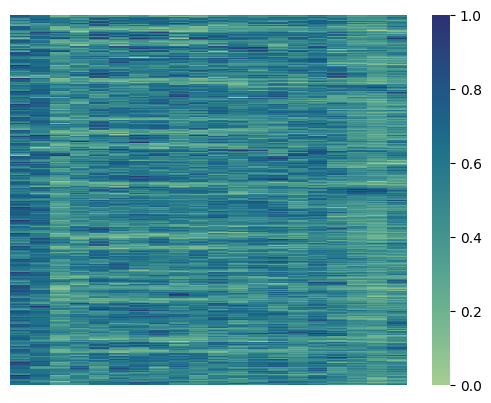

In [4]:
sns.heatmap(gtzan_Data[10],cmap='crest', xticklabels=False, yticklabels=False)

In [5]:
label_encoder = LabelEncoder()
gtzan_Label = label_encoder.fit_transform(gtzan_Label)

In [6]:
def create_sandwiched_vgg19(input_shape=(2584, 20, 1), num_classes=10):
    inputs = layers.Input(shape=input_shape)

    # Initial Convolutional Layers
    x = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(inputs)
    x = layers.MaxPooling2D((8, 2))(x)
    x = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(x)
    x = layers.MaxPooling2D((8, 2))(x)
    x = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(x)
    x = layers.Conv2D(3, (3, 3), activation='relu', padding='same')(x)
    x = layers.UpSampling2D(size=(8, 8))(x)
    base_model = tf.keras.applications.VGG19(weights='imagenet', include_top=False, input_shape=(320, 40, 3))
    base_model.trainable = False
    x = base_model(x)
    x = layers.Flatten()(x)
    x = layers.Dense(512, activation='relu')(x)
    x = layers.Dropout(0.3)(x)
    outputs = layers.Dense(num_classes, activation='softmax')(x)
    model = Model(inputs, outputs)
    return model
model = create_sandwiched_vgg19()
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])
model.summary()

80134624/80134624 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 2584, 20, 1)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 2584, 20, 128)  │         1,280 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 323, 10, 128)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 323, 10, 64)    │        73,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 40, 5, 64)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 40, 5, 32)      │        18,464 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 40, 5, 3)       │           867 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling2d (UpSampling2D)    │ (None, 320, 40, 3)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ vgg19 (Functional)              │ (None, 10, 1, 512)     │    20,024,384 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 5120)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │     2,621,952 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 10)             │         5,130 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 22,745,869 (86.77 MB)

 Trainable params: 2,721,485 (10.38 MB)

 Non-trainable params: 20,024,384 (76.39 MB)

In [7]:
Data = np.array(gtzan_Data)
labels = np.array(gtzan_Label)
X_train, X_test, y_train, y_test = train_test_split(Data, labels, test_size=0.1, random_state=42)

In [8]:
model.fit(X_train,y_train,epochs = 50,batch_size = 32,validation_split = 0.2)

Epoch 1/50


I0000 00:00:1730595755.955863     114 service.cc:145] XLA service 0x7a269c014a30 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1730595755.955934     114 service.cc:153]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0


 2/23 ━━━━━━━━━━━━━━━━━━━━ 1s 88ms/step - accuracy: 0.1406 - loss: 3.0027 

I0000 00:00:1730595767.282220     114 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


23/23 ━━━━━━━━━━━━━━━━━━━━ 32s 829ms/step - accuracy: 0.1052 - loss: 2.9078 - val_accuracy: 0.1111 - val_loss: 2.3831
Epoch 2/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 2s 93ms/step - accuracy: 0.0975 - loss: 2.4331 - val_accuracy: 0.1222 - val_loss: 2.3411
Epoch 3/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 2s 93ms/step - accuracy: 0.1224 - loss: 2.3289 - val_accuracy: 0.1389 - val_loss: 2.3248
Epoch 4/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 2s 92ms/step - accuracy: 0.0753 - loss: 2.3261 - val_accuracy: 0.0444 - val_loss: 2.3252
Epoch 5/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 2s 93ms/step - accuracy: 0.1209 - loss: 2.3032 - val_accuracy: 0.0833 - val_loss: 2.3056
Epoch 6/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 2s 92ms/step - accuracy: 0.0798 - loss: 2.2995 - val_accuracy: 0.0500 - val_loss: 2.3186
Epoch 7/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 2s 93ms/step - accuracy: 0.1293 - loss: 2.2987 - val_accuracy: 0.0833 - val_loss: 2.3019
Epoch 8/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 2s 92ms/step - accuracy: 0.1222 - loss: 2.3018 - val_accuracy: 0.0833 - val_loss: 

In [9]:
loss , accuracy = model.evaluate(X_test,y_test)

4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 599ms/step - accuracy: 0.3800 - loss: 1.9377


## Fine tuning on our data

In [10]:
L = 2584  # Target number of frames
Data = []
Label = []
scaler = MinMaxScaler()
folder_path = '/kaggle/input/ds203-songs'
folder_names = os.listdir(folder_path)

for folder in folder_names:
    folder__names = os.listdir(os.path.join(folder_path, folder))
    for folder_ in folder__names:
        file_names = os.listdir(os.path.join(folder_path, folder, folder_))
        for file in file_names:
            file_path = os.path.join(folder_path, folder, folder_, file)
            mfcc_data = create_MFCC_coefficients(file_path)
            if mfcc_data is not None:
                mfcc_data_scaled = scaler.fit_transform(mfcc_data)
                if len(mfcc_data_scaled) < L:
                    padding = L - len(mfcc_data_scaled)
                    mfcc_data_scaled = np.pad(mfcc_data_scaled, ((padding // 2, padding - padding // 2), (0, 0)), mode='constant')
                elif len(mfcc_data_scaled) > L:
                    mfcc_data_scaled = mfcc_data_scaled[:L, :]
                Data.append(np.array(mfcc_data_scaled))
                Label.append(folder_)

In [11]:
label_encoder = LabelEncoder()
labels = label_encoder.fit_transform(Label)

In [12]:
Feature_extractor = Model(inputs=model.input,outputs=model.get_layer('dense').output)

In [13]:
x = layers.Dense(6, activation='softmax')(Feature_extractor.output)
fine_tuned_model = Model(inputs=Feature_extractor.input, outputs=x)
fine_tuned_model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
fine_tuned_model.summary()

Model: "functional_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 2584, 20, 1)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 2584, 20, 128)  │         1,280 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 323, 10, 128)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 323, 10, 64)    │        73,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 40, 5, 64)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 40, 5, 32)      │        18,464 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 40, 5, 3)       │           867 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling2d (UpSampling2D)    │ (None, 320, 40, 3)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ vgg19 (Functional)              │ (None, 10, 1, 512)     │    20,024,384 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 5120)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │     2,621,952 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 6)              │         3,078 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 22,743,817 (86.76 MB)

 Trainable params: 2,719,433 (10.37 MB)

 Non-trainable params: 20,024,384 (76.39 MB)

In [14]:
Data = np.array(Data)
labels = np.array(labels)
X_train, X_test, y_train, y_test = train_test_split(Data, labels, test_size=0.05, random_state=42)

In [15]:
fine_tuned_model.fit(X_train,y_train,epochs = 20,batch_size = 32,validation_split = 0.2)

Epoch 1/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 21s 9s/step - accuracy: 0.0758 - loss: 2.1181 - val_accuracy: 0.1364 - val_loss: 1.7966
Epoch 2/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 107ms/step - accuracy: 0.2023 - loss: 1.7371 - val_accuracy: 0.2727 - val_loss: 1.8092
Epoch 3/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 105ms/step - accuracy: 0.2355 - loss: 1.6261 - val_accuracy: 0.3182 - val_loss: 1.8573
Epoch 4/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 106ms/step - accuracy: 0.2783 - loss: 1.5834 - val_accuracy: 0.2727 - val_loss: 1.8473
Epoch 5/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 105ms/step - accuracy: 0.3171 - loss: 1.5018 - val_accuracy: 0.3182 - val_loss: 1.8037
Epoch 6/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 105ms/step - accuracy: 0.3597 - loss: 1.4773 - val_accuracy: 0.3636 - val_loss: 1.7700
Epoch 7/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 106ms/step - accuracy: 0.4261 - loss: 1.4038 - val_accuracy: 0.3636 - val_loss: 1.7807
Epoch 8/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 106ms/step - accuracy: 0.4417 - loss: 1.3661 - val_accuracy: 0.3636 - val_loss: 1

In [16]:
loss , accuracy = model.evaluate(X_test,y_test)

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - accuracy: 0.1667 - loss: 8.2841


## Predicting for the given data

In [17]:
scaler = MinMaxScaler()
folder_path = '/kaggle/input/ds203-v2-dataset/MFCC-files-v2-20241024'
file_names = os.listdir(folder_path)
Data = []
meta_data = []
for file in file_names:
    file_path = os.path.join(folder_path,file)
    meta_data.append(file)
    df = pd.read_csv(file_path,header=None)
    mfcc_data = df.T
    mfcc_data_scaled = pd.DataFrame(scaler.fit_transform(mfcc_data))
    if len(mfcc_data_scaled) < L:
        padding = L - len(mfcc_data_scaled)
        mfcc_data_scaled = np.pad(mfcc_data_scaled, ((padding // 2, padding - padding // 2), (0, 0)), mode='constant')
    elif len(mfcc_data_scaled) > L:
        mfcc_data_scaled = mfcc_data_scaled.iloc[:L, :]
    Data.append(mfcc_data_scaled)
Data = np.array(Data)

In [18]:
predictions = fine_tuned_model.predict(Data)
predicted_labels = predictions.argmax(axis=1)
original_labels = label_encoder.inverse_transform(predicted_labels)

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 255ms/step


In [19]:
result_df = pd.DataFrame({'Label': original_labels, 'MetaData': meta_data})
result_df.to_csv('result.csv', index=False)
result_df.head()

,Label,MetaData
0,KISHORE_KUMAR,70-MFCC.csv
1,Marathi Bhav Geet Songs,104-MFCC.csv
2,Marathi Bhav Geet Songs,67-MFCC.csv
3,KISHORE_KUMAR,110-MFCC.csv
4,Marathi Bhav Geet Songs,92-MFCC.csv
